In [1]:
import sys
sys.path.append('./source_code')

In [10]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, \
    KFold, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
    roc_auc_score, roc_curve, confusion_matrix
import xgboost as xgb
import classification_helpers as ch

%config InlineBackend.figure_format = 'svg'
%matplotlib inline
sns.set(color_codes=True)
plt.style.use('seaborn-colorblind')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.precision', 2)
pd.set_option('display.max_info_columns', 200)

In [3]:
with open('pickles/combined_sample_weather_df5.pickle', 'rb') as read_file:
    sample_df = pickle.load(read_file)

In [4]:
# with open('pickles/cv_records_df.pickle', 'rb') as read_file:
#     cv_records_df = pickle.load(read_file)

In [5]:
with open('pickles/records_df.pickle', 'rb') as read_file:
    records_df = pickle.load(read_file)

In [6]:
# with open('pickles/records_df.pickle', 'wb') as to_write:
#     pickle.dump(records_df, to_write)

In [7]:
base_numerical_features = ['airline_avg_arrival_delay',
                           'origin_airport_avg_flights_per_day',
                           'origin_airport_avg_departure_delay',
                           'destination_airport_avg_flights_per_day',
                           'destination_airport_avg_arrival_delay',
                           'month_avg_delay',
                           'day_of_week_avg_delay']

weather_numerical_features = ['Precipitation_origin',
                              'Snow Depth_origin',
                              'Visibility_origin',
                              'Wind Speed_origin',                      
                              'Precipitation_destination',
                              'Snow Depth_destination',
                              'Visibility_destination',
                              'Wind Speed_destination']
                              

weather_categorical_features = ['is_Clear_origin',
                                'is_Partially cloudy_origin',
                                'is_Rain_origin',
                                'is_Snow_origin',
                                'is_Overcast_origin',
                                'is_Clear_destination',
                                'is_Partially cloudy_destination',
                                'is_Rain_destination',
                                'is_Snow_destination',
                                'is_Overcast_destination']

base_categorical_features = ['American Airlines Inc.', 'American Eagle Airlines Inc.',
                             'Atlantic Southeast Airlines', 'Delta Air Lines Inc.',
                             'Frontier Airlines Inc.', 'Hawaiian Airlines Inc.', 'JetBlue Airways',
                             'Skywest Airlines Inc.', 'Southwest Airlines Co.', 'Spirit Air Lines',
                             'US Airways Inc.', 'United Air Lines Inc.', 'Virgin America',
                             'is_thanksgiving_period', 'is_xmas_period',
                             'is_night_departure', 'is_night_arrival']

target = ['is_not_on_time']

all_features = (base_numerical_features 
                + base_categorical_features 
                + weather_numerical_features)

In [6]:
sample_df.head()

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft,weather_delay,airline_name,origin_airport_name,origin_airport_city,origin_airport_state,origin_airport_latitude,origin_airport_longitude,destination_airport_name,destination_airport_city,destination_airport_state,destination_airport_latitude,destination_airport_longitude,is_not_on_time,airline_avg_arrival_delay,airline_total_diversions,airline_total_cancellations,airline_total_flights,airline_percent_diversions_cancellations,American Airlines Inc.,American Eagle Airlines Inc.,Atlantic Southeast Airlines,Delta Air Lines Inc.,Frontier Airlines Inc.,Hawaiian Airlines Inc.,JetBlue Airways,Skywest Airlines Inc.,Southwest Airlines Co.,Spirit Air Lines,US Airways Inc.,United Air Lines Inc.,Virgin America,origin_airport_avg_arrival_delay,origin_airport_total_flights,origin_airport_avg_flights_per_day,destination_airport_avg_arrival_delay,destination_airport_total_flights,destination_airport_avg_flights_per_day,airline_specific_delay_total_count,airline_specific_delay_%_freq,airline_late_aircraft_total_count,airline_late_aircraft_delay_%_freq,month_avg_delay,day_of_week_avg_delay,is_thanksgiving_period,is_xmas_period,is_night_departure,is_night_arrival,airline_avg_departure_delay,airline_avg_taxi_out,airline_avg_taxi_in,origin_airport_avg_departure_delay,origin_airport_avg_taxi_out,origin_airport_avg_taxi_in,destination_airport_avg_taxi_in,date_str,origin_airport_coordinates,destination_airport_coordinates,Address_origin,Cloud Cover_origin,Conditions_origin,Date time_origin,Dew Point_origin,Heat Index_origin,Info_origin,Latitude_origin,Longitude_origin,Maximum Temperature_origin,Minimum Temperature_origin,Name_origin,Precipitation_origin,Precipitation Cover_origin,Relative Humidity_origin,Resolved Address_origin,Sea Level Pressure_origin,Snow Depth_origin,Temperature_origin,Visibility_origin,Weather Type_origin,Wind Chill_origin,Wind Direction_origin,Wind Gust_origin,Wind Speed_origin,Address_destination,Cloud Cover_destination,Conditions_destination,Date time_destination,Dew Point_destination,Heat Index_destination,Info_destination,Latitude_destination,Longitude_destination,Maximum Temperature_destination,Minimum Temperature_destination,Name_destination,Precipitation_destination,Precipitation Cover_destination,Relative Humidity_destination,Resolved Address_destination,Sea Level Pressure_destination,Snow Depth_destination,Temperature_destination,Visibility_destination,Weather Type_destination,Wind Chill_destination,Wind Direction_destination,Wind Gust_destination,Wind Speed_destination,is_Overcast_origin,is_Rain_origin,is_Snow_origin,is_Partially cloudy_origin,is_Clear_origin,is_Overcast_destination,is_Rain_destination,is_Snow_destination,is_Partially cloudy_destination,is_Clear_destination
0,2015,2,13,5,EV,4210,N26141,IAH,BNA,1904,1900,-4.0,18.0,1918,107,113.0,89.0,657,2047,6.0,2051,2053,2.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Atlantic Southeast Airlines,George Bush Intercontinental Airport,Houston,TX,29.98,-95.34,Nashville International Airport,Nashville,TN,36.12,-86.68,0,11.72,46,254,9877,3.04,0,0,1,0,0,0,0,0,0,0,0,0,0,10.82,2540.0,6.96,6.90,815.0,2.23,902.0,9.13,964.0,9.76,17.14,6.63,0,0,0,1,9.0,16.67,7.62,12.04,17.83,7.12,6.28,2015-02-13,"29.98047,-95.33972","36.12448,-86.67818","29.98047,-95.33972",39.3,Partially cloudy,02/13/2015,39.6,NaN,,29.98,-95.34,65.9,39,,0.0,0.0,64.60,"29.98047,-95.33972",1026.6,0.0,52.2,1.0,,34.7,135.13,NaN,12.7,"36.12448,-86.67818",51.5,Partially cloudy,02/13/2015,9.9,NaN,,36.12,-86.68,35.9,19.1,,0.00,0.00,50.54,"36.12448,-86.67818",1026.9,0.0,26.8,1.0,,10.2,251.40,NaN,8.1,0,0,0,1,0,0,0,0,1,0
1,2015,2,9,1,EV,4670,N41104,ORD,MCI,1000,0958,-2.

In [8]:
X, y = ch.feature_target_selection(all_features, target, sample_df)

X_train_val, X_test, y_train_val, y_test = ch.initial_split(X, y.values.ravel())
X_train, X_val, y_train, y_val = ch.second_split(X_train_val, y_train_val)

lm = LogisticRegression(penalty='none', max_iter=10000)
lm_balanced = LogisticRegression(penalty='none', max_iter=10000, class_weight='balanced')

rf = RandomForestClassifier()
rf_balanced = RandomForestClassifier(n_estimators=100, max_depth=6, class_weight='balanced')

In [61]:
gbm = xgb.XGBClassifier(
    n_estimators=250, 
    max_depth=6,
    objective='binary:logistic',
    learning_rate=.1,
    subsample=.7,
    min_child_weight=1,
    colsample_bytree=1,
    scale_pos_weights=4
)

eval_set = [(X_train, y_train), (X_val, y_val)]

# gbm.fit(
#     X_train, y_train, 
#     eval_set=eval_set,
#     eval_metric='auc',
#     early_stopping_rounds=20,
#     verbose=True
# )

In [60]:
records_df = ch.cv(gbm, X_train_val, y_train_val, records_df, scale=True)

CROSS VALIDATION
Model name: XGBClassifier
Hyperparameters: base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=1, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=250, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, scale_pos_weights=4, subsample=0.7,
              tree_method=None, validate_parameters=False, verbosity=None

Train F1:                                 0.20
Val F1:                                   0.17
Train precision:                          0.71
Val precision:                            0.62
Train recall:                             0.12
Val recall:                               0.10
Train accuracy:              

In [38]:
_, records_df = ch.simple_validate(lm_balanced, X_train, X_val,
                                   y_train, y_val,
                                   records_df, threshold=0.47,
                                   scale=True)

SIMPLE VALIDATION
Model name: LogisticRegression
Hyperparameters: class_weight='balanced', max_iter=10000, penalty='none'

Train F1:                                 0.40
Val F1:                                   0.39
Train precision:                          0.28
Val precision:                            0.28
Train recall:                             0.66
Val recall:                               0.66
Train accuracy:                           0.60
Val accuracy:                             0.59
Train AUC:                                0.62
Val AUC:                                  0.62

Feature coefficients:

airline_avg_arrival_delay                 0.06
origin_airport_avg_flights_per_day        0.03
origin_airport_avg_departure_delay        0.13
destination_airport_avg_flights_per_day   0.03
destination_airport_avg_arrival_delay     0.12
month_avg_delay                           0.22
day_of_week_avg_delay                     0.04
American Airlines Inc.                   -0.03
America

In [14]:
sample_df['is_not_on_time'].value_counts()

0    79845
1    20121
Name: is_not_on_time, dtype: int64

In [51]:
records_df

,model,validation_type,iteration_desc,feature_engineering,hyperparameter_tuning,train_f1,val_f1,train_precision,val_precision,train_recall,val_recall,train_accuracy,val_accuracy,train_AUC,val_AUC
0,LogisticRegression,simple,testing,,"max_iter=10000, penalty='none'",0.11,0.11,0.60,0.59,0.06,0.06,0.80,0.80,0.53,0.53
1,LogisticRegression,simple,testing,,"max_iter=10000, penalty='none'",0.11,0.11,0.60,0.59,0.06,0.06,0.80,0.80,0.53,0.53
2,RandomForestClassifier,simple,testing,,,0.97,0.21,0.99,0.58,0.94,0.13,0.99,0.81,0.97,0.55
3,XGBClassifier,simple,testing,,"base_score=0.5, booster=None, colsample_byleve...",0.37,0.23,0.89,0.61,0.23,0.14,0.84,0.81,0.61,0.56
4,LogisticRegression,cv,testing,,"max_iter=10000, penalty='none'",0.11,0.11,0.60,0.60,0.06,0.06,0.80,0.80,0.67,0.67
5,LogisticRegression,cv,final logistic regression baseline,,"max_iter=10000, penalty='none'",0.11,0.11,0.60,0.60,0.06,0.06,0.80,0.80,0.67,0.67
6,LogisticRegression,cv,trying to optimize my F1 score using 'balanced...,,"class_weight='balanced', max_iter=10000, penal...",0.40,0.40,0.30,0.30,0.58,0.58,0.65,0.64,0.67,0.67
7,LogisticRegression,cv,trying 2x class weights,,"class_weight={0: 1, 1: 2}, max_iter=10000, pen...",0.29,0.29,0.43,0.43,0.22,0.22,0.79,0.79,0.67,0.67
8,LogisticRegression,cv,trying 3x class weights,,"class_weight={0: 1, 1: 3}, max_iter=10000, pen...",0.38,0.38,0.35,0.35,0.41,0.41,0.73,0.73,0.67,0.67
9,LogisticRegression,cv,trying 4x class weights,,"class_weight={0: 1, 1: 4}, max_iter=10000, pen...",0.40,0.40,0.30,0.30,0.58,0.58,0.64,0.64,0.67,0.67


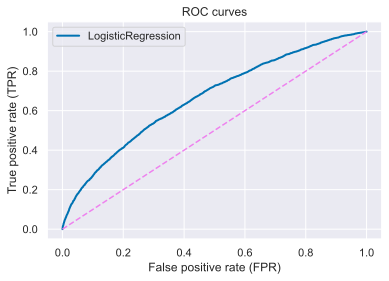

In [11]:
fpr, tpr, thresholds = ch.plot_ROC(lm_balanced, X_train, X_val, y_train, y_val)

In [8]:
best_f1_score, best_threshold = ch.get_optimal_f1_threshold(lm_balanced, X_train, X_val, y_train, y_val)

In [9]:
best_f1_score, best_threshold

(0.3920153211549794, 0.46836836836836837)

In [9]:
ch.test_scores(lm_balanced, X_train_val, X_test,
               y_train_val, y_test,
               threshold=.47, scale=True)

Model name: LogisticRegression
Hyperparameters: class_weight='balanced', max_iter=10000, penalty='none'

Train F1:                                 0.40
Test F1:                                  0.39
Train precision:                          0.28
Test precision:                           0.28
Train recall:                             0.66
Test recall:                              0.65
Train accuracy:                           0.60
Test accuracy:                            0.59
Train AUC:                                0.62
Test AUC:                                 0.61

Feature coefficients:

airline_avg_arrival_delay                 0.06
origin_airport_avg_flights_per_day        0.02
origin_airport_avg_departure_delay        0.13
destination_airport_avg_flights_per_day   0.04
destination_airport_avg_arrival_delay     0.11
month_avg_delay                           0.22
day_of_week_avg_delay                     0.04
American Airlines Inc.                   -0.02
American Eagle Airlines I